# Plotting Euler angles on a pole figure


We want to take 3 euler angles and use them to turn the lattice basis vectors into a matrix of vectors in the sample reference frame. This is just given by:

$$A=I \, G$$

## Orientation matrix from euler angles 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

The function below creates an orientation matrix from (Bunge) Euler angles. By default it produces a matrix using the passive interpretation of the rotation, in which the reference frame is rotated. This is the usual convention used to represent crystallographic orientations. Using a passive rotation, the relationship between the sample reference frame, $C_S$ and the crystal reference frame, $C_C$ is given by the matrix multiplication:

$$C_C=G\,C_S$$

The inverse operation is given by:

$$C_S=G^{-1}\,C_C$$ which for the orientation matrix is equivalent to: $$C_S=G^{T}\,C_C$$

In [4]:
def ori_matrix(phi1,Phi,phi2,passive=True):
    phi1=np.radians(phi1)
    Phi=np.radians(Phi)
    phi2=np.radians(phi2)
    R11 = np.cos(phi1)*np.cos(phi2)-np.sin(phi1)*np.cos(Phi)*np.sin(phi2)
    R12 = np.sin(phi1)*np.cos(phi2)+ np.cos(phi1)*np.cos(Phi)*np.sin(phi2)
    R13 = np.sin(phi2)*np.sin(Phi)
    R21 = -np.cos(phi1)*np.sin(phi2)-np.sin(phi1)*np.cos(Phi)*np.cos(phi2)
    R22 = - np.sin(phi1)*np.sin(phi2)+np.cos(phi1)*np.cos(Phi)*np.cos(phi2)
    R23 = np.cos(phi2)*np.sin(Phi)
    R31 = np.sin(phi1)*np.sin(Phi)
    R32= -np.sin(Phi)*np.cos(phi1)
    R33= np.cos(Phi)
    matrix=np.matrix([[R11,R12,R13],[R21,R22,R23],[R31,R32,R33]])
    if not passive: # matrix above is for the passive rotation 
        matrix=matrix.transpose()
    return matrix

In [5]:
g_ori = ori_matrix(54,108,43)
print(g_ori)

[[ 0.60037851  0.46780237  0.64861898]
 [-0.21803015 -0.68458816  0.6955587 ]
 [ 0.76942088 -0.55901699 -0.30901699]]


The inverse of a rotation is the transpose:

In [6]:
np.linalg.inv(g_ori)

matrix([[ 0.60037851, -0.21803015,  0.76942088],
        [ 0.46780237, -0.68458816, -0.55901699],
        [ 0.64861898,  0.6955587 , -0.30901699]])

In [8]:
np.isclose(np.linalg.inv(g_ori), g_ori.T)

matrix([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

# Plotting on a pole figure

Given an orientation matrix $G$, different poles can be plotted by transforming the crystal vectors into sample coordinates and then plotting them. This means using:

$$C_S=G^{-1}\,C_C$$


This section is from the documentation for [orilib](https://sourceforge.net/projects/orilib/) by Roman Key.

If $\left(hkl\right)$ is the pole of interest and
$n=\sqrt{h^2+k^2+l^2}$, $\alpha$ and
$\beta$ are given by,


$$
\left(\matrix{
    \sin \alpha \cos \beta \cr
    \sin \alpha \sin \beta \cr
    \cos \alpha \cr
}\right)
=
1/n
\left(\matrix{
g_{11} & g_{21} & g_{31} \cr
g_{12} & g_{22} & g_{32} \cr
g_{13} & g_{23} & g_{33} \cr
}\right)
\left(\matrix{
    h \cr
    k \cr
    l \cr
}\right)
$$


Then, $P$ is projected onto the equatorial plane,
${X_s}-{Y_s}$. The position of the
projection point, $math$, can be described by polar coordinates
$\left(Op, \beta\right)$.

- The stereographic projection is commonly used in metallurgy since angular relationships in the crystal are preserved in the projection.  ${p}$ is the point of intersection of segment $[PS]$ with the projection plane. ${Op}$ is given by,

$$
Op = \tan \left(\alpha / 2\right)
$$


- The equal-area projection is commonly used in geology. Areas are preserved in the projection, so it is particularly appropriate for the measurements of population densities.  $Op$ is given by,


$$
Op = \sqrt{2} \sin \left(\alpha / 2\right)
$$



In [12]:
def get_proj(g,pole,proj='stereo'):
    '''Return polar projection (and vector) for a given
       Orientation matrix and pole'''
    n=np.linalg.norm(pole)
    pole=np.matrix(pole).T/n
    vector=g.T*pole #invert matrix
    alpha=np.arccos(vector[2])
    # print(vector[2])
    if np.isclose(alpha,0.0):
        beta=np.matrix([0.0])
    else:
        beta=np.arctan2(vector[1]/np.sin(alpha),vector[0]/np.sin(alpha))
    
    if alpha>np.pi/2:
        alpha = np.pi-alpha
        beta += np.pi
    
    if proj=='stereo':
        Op=np.tan(alpha/2)
    if proj=='equal area':
        Op=np.sqrt(2)*np.sin(alpha/2)
    else:
        exit
    return Op, beta,vector

In [13]:
def plot_poles(beta_list, Op_list):
    """Plots poles from lists of polar coordinates"""
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='polar')
    for beta, Op in zip(beta_list, Op_list):
        ax.plot(beta, Op,'o',ms=18, alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylim([0,1.0])

In [14]:
def get_vectors(g,pole_list, proj='stereo'):
    """Returns the list of polar coordinates and 
       vectors for one of the three poles"""
    Op_list=[]
    beta_list=[]
    vector_list=[]
    
    for pole in pole_list:
        Op,beta,vector=get_proj(g,pole,proj)
   #     if vector[-1]>0:
        Op_list.append(Op)
        beta_list.append(beta)
        vector_list.append(vector)
    
    return Op_list, beta_list, vector_list

In [15]:
def get_pole_list(pole='001'):
    """Returns list of common cubic poles"""
    pole_dict = {
        '001': [np.array([1,0,0]), np.array([0,1,0]),np.array([0,0,1]),
               np.array([-1,0,0]), np.array([0,-1,0]),np.array([0,0,-1])],
        '110': [np.array([1,1,0]), np.array([1,0,1]),np.array([0,1,1]),
               np.array([-1,-1,0]), np.array([-1,0,-1]),np.array([0,-1,-1]),
               np.array([-1,1,0]), np.array([-1,0,1]),np.array([0,-1,1]),
               np.array([1,-1,0]), np.array([1,0,-1]),np.array([0,1,-1])],
        '111': [np.array([1,1,1]), np.array([-1,1,1]),np.array([1,-1,1]), np.array([1,1,-1]),
               np.array([-1,-1,-1]), np.array([-1,-1,1]),np.array([1,-1,-1]), np.array([-1,1,-1])]
    }
    pole_list=pole_dict[pole]
    return pole_list


In [16]:
def plot_pole(g, pole='001', legend=False):
    """Plots poles for a given orientation"""
    pole_list=get_pole_list(pole)
    Op_list, beta_list, vector_list=get_vectors(g,pole_list)
    plot_poles(beta_list, Op_list)
    if legend:
        plt.legend(pole_list,bbox_to_anchor=(1.5, 1.05))
    #return beta_list, Op_list
    
def plot_all_poles(g, proj= 'stereo', fig = None):
    """Plots all 3 main cubic pole figures for a given orientation"""
    poles=['001','110','111']
    if fig == None:
        fig = plt.figure(figsize=(10,30))
    for n, pole in enumerate(poles):
        pole_list=get_pole_list(pole)
        Op_list, beta_list, vector_list=get_vectors(g,pole_list,proj)
        ax = fig.add_subplot(1,3,n+1, projection='polar')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_ylim([0,1.0])
        ax.set_title(pole)
        for beta, Op in zip(beta_list, Op_list):
            ax.plot(beta, Op,'ro',ms=12, alpha=0.5)

In the standard projection, the rotation is zero (all euler angles are zero):

In [17]:
g=ori_matrix(0,0,0)

In [18]:
print(g)

[[ 1.  0.  0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]]


Plotting 100 poles:

/home/joao/miniconda3/envs/py3/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


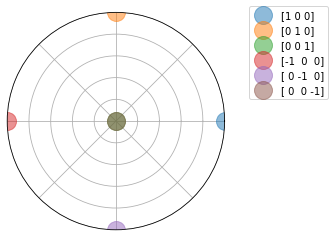

In [22]:
plot_pole(g,'001',legend=True)

Plotting 111 poles:

/home/joao/miniconda3/envs/py3/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


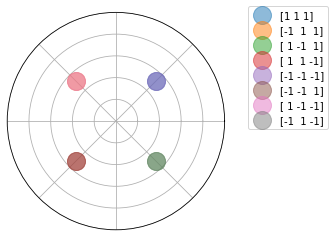

In [19]:
plot_pole(g,'111',legend=True)

Plot all poles:

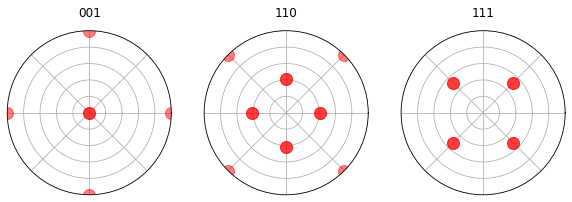

In [23]:
plot_all_poles(g,proj='stereo')